In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d 
from scipy.signal import gaussian
import tensorflow as tf
from tensorflow.keras import Sequential, initializers
from tensorflow.keras.layers import LSTM, Dense
from math import ceil
%matplotlib inline

In [3]:
# Constants
vocab_size = 1
n = 1 # Number of features
data_split_ratio = np.array([0.6, 0.2, 0.2]) # Training, Validating, Testing

In [9]:
# Uploading the data
filename = "../data/SN_d_tot_V2.0.csv"
#uploaded = files.upload()

In [10]:
# Getting the data
headers = ["Year",
           "Month",
           "Day",
           "Decimal Date",
           "Daily Total Sunspot Number",
           "Sunspot Number Stddev",
           "No of observations",
           "Definitive/Provisional"
]
  
data = pd.read_csv(filename, delimiter=";", names=headers)

In [ ]:
#data

In [11]:
# Hyper-Parameters
mean_length = 31
batch_size = 32
timesteps = 10
learning_rate = 0.001
epochs = 5
hidden_layer_size_1 = 64
hidden_layer_size_2 = 64
loss_func = "mse"

In [12]:
# Data Preprocessing

# Set unknown numbers to NaN first
mask = data["Daily Total Sunspot Number"] == -1
data.loc[mask, "Daily Total Sunspot Number"] = np.nan

# Remove the starting NaNs. Can't do anything about them.
i = 0
while i < data.shape[0]:
  if not mask[i]:
    break
  i += 1

data = data.drop(range(i))
mask = mask[i:]
#print(mask)

# Just remove the NaN data rows
#data = data.dropna()

# Data Variables
x = np.array(data["Decimal Date"])
y = np.array(data["Daily Total Sunspot Number"])

# Interpolate and fill in the missing data
interp = interp1d(x[~mask], y[~mask], kind="linear", bounds_error=False)
data.loc[mask, "Daily Total Sunspot Number"] = interp(x[mask])

# Update the variables
x = np.array(data["Decimal Date"])
y = np.array(data["Daily Total Sunspot Number"])

# Normalise the data
y = (y - np.mean(y)) / (6*np.sqrt(np.var(y)))
x = x - x.min()

print("x.shape:", x.shape)
print("y.shape:", y.shape)

x.shape: (73741,)
y.shape: (73741,)


In [13]:
# Smoothen the data by taking a running mean.

def running_mean(y, weights):
  return np.convolve(y, weights, mode="valid")

weights = gaussian(M=mean_length, std=mean_length, sym=True)
y = running_mean(y, weights)


In [14]:
#data

In [15]:
def sliding_window(x, timesteps):
  shape = (x.shape[0]-timesteps, timesteps, n)
  x_slid = np.zeros(shape)

  for i in range(shape[0]):
    x_slid[i] = x[i: i+timesteps].reshape(timesteps, n)

  return x_slid

def to_sliding_window(x, y, timesteps):
  # Gets the sliding window version of x and cuts the y data appropriately
  xnew = sliding_window(x, timesteps)
  #print(xnew)
  ynew = y[timesteps:]
  return xnew, ynew

def batch_adjustment(x, y, batch_size):
  assert x.shape[0] == y.shape[0], "x and y are not of same length (dim 0) x:%s y:%s" % (x.shape, y.shape)
  l = x.shape[0]
  lnew = int((l // batch_size) * batch_size)
  return x[:lnew], y[:lnew]

def sliding_window_main(x, y): 
  """
  Just a wrapper function to allow use during iteration while making
  learning curves.
  """
  x_slid, y_slid = to_sliding_window(x, y, timesteps)
  reshape_2 = lambda y: np.reshape(y, (y.shape[0], n))
  y_slid = reshape_2(y_slid)
  
  print("x_slid.shape:", x_slid.shape)
  print("y_slid.shape:", y_slid.shape)

  return x_slid, y_slid


x_slid, y_slid = sliding_window_main(x, y)

x_slid.shape: (73731, 10, 1)
y_slid.shape: (73701, 1)


In [16]:
# Data Splitting
def split_data(x, y, ratio):
  """
  Splits the data into training, validation and testing sets
  for x and y in the given ratio.
  """
  m = x.shape[0]
  splitter = np.cumsum(ratio)
  train_start = 0
  val_start = batch_size * ((splitter[0] * m) // batch_size) 
  test_start = batch_size * ((splitter[1] * m) // batch_size)
  test_end = batch_size * ((splitter[2] * m) // batch_size)

  val_start = int(val_start)
  test_start = int(test_start)
  test_end = int(test_end)

  split = ( x[train_start:val_start, :], y[train_start:val_start, :],
           x[val_start:test_start, :], y[val_start:test_start, :],
           x[test_start:test_end, :], y[test_start:test_end, :]
  )

  return split

def data_splitting_main(x_slid, y_slid):
  """
  Just a wrapper function to allow use during iteration while making
  learning curves.
  """
  x_train, y_train, x_val, y_val, x_test, y_test = split_data(x_slid, y_slid, data_split_ratio)
  
  print('x_train.shape: ', x_train.shape)
  print('y_train.shape: ', y_train.shape)
  print('x_val.shape: ', x_val.shape)
  print('y_val.shape: ', y_val.shape)
  print('x_test.shape: ', x_test.shape)
  print('y_test.shape: ', y_test.shape)
  print()

  return x_train, y_train, x_val, y_val, x_test, y_test


x_train, y_train, x_val, y_val, x_test, y_test = data_splitting_main(x_slid, y_slid)

x_train.shape:  (44224, 10, 1)
y_train.shape:  (44224, 1)
x_val.shape:  (14752, 10, 1)
y_val.shape:  (14752, 1)
x_test.shape:  (14752, 10, 1)
y_test.shape:  (14725, 1)



In [37]:
# Creating the Network
def create_network():
  net = Sequential()
  net.add(LSTM(hidden_layer_size_1, batch_size=batch_size, input_shape=(timesteps, n),
               stateful=True, activation="tanh"))
  net.add(Dense(n))
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  net.compile(loss=loss_func, optimizer=optimizer)

  return net

config = {
    "Running Mean Length" : mean_length,
    "Batch Size" : batch_size,
    "Timesteps" : timesteps,
    "Learning Rate" : learning_rate,
    "Epochs" : epochs,
    "Loss Function": loss_func
}

layers = "Hidden Layer : " + str(hidden_layer_size_1)
configtxt = "\n".join([key + " : " + str(val) for (key, val) in config.items()]) + "\n" + layers

net = create_network()

In [38]:
def trainer(net, x_train, y_train, x_val, y_val, verbose=0):
  #print('Training')
  history = net.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=verbose,
          validation_data=(x_val, y_val),
          shuffle=False)
    
  return history



history = trainer(net, x_train, y_train, x_val, y_val, verbose=1)
var_train = np.var(y_train)
var_val = np.var(y_val)
print("Variance in y_train:", var_train)
print("Variance in y_val:", var_val)

Train on 44224 samples, validate on 14752 samples
Epoch 1/5
44224/44224 [==============================] - 17s 395us/sample - loss: 15.7277 - val_loss: 27.8502
Epoch 2/5
44224/44224 [==============================] - 13s 293us/sample - loss: 15.3382 - val_loss: 28.0311
Epoch 3/5
44224/44224 [==============================] - 13s 293us/sample - loss: 15.2784 - val_loss: 28.1760
Epoch 4/5
44224/44224 [==============================] - 13s 301us/sample - loss: 15.2971 - val_loss: 28.0426
Epoch 5/5
44224/44224 [==============================] - 14s 321us/sample - loss: 15.1947 - val_loss: 27.9539
Variance in y_train: 15.883306794815006
Variance in y_val: 24.35389111750572


In [39]:
var_train = np.var(y_train)
var_val = np.var(y_val)
print("Variance in y_train:", var_train)
print("Variance in y_val:", var_val)

Variance in y_train: 15.883306794815006
Variance in y_val: 24.35389111750572


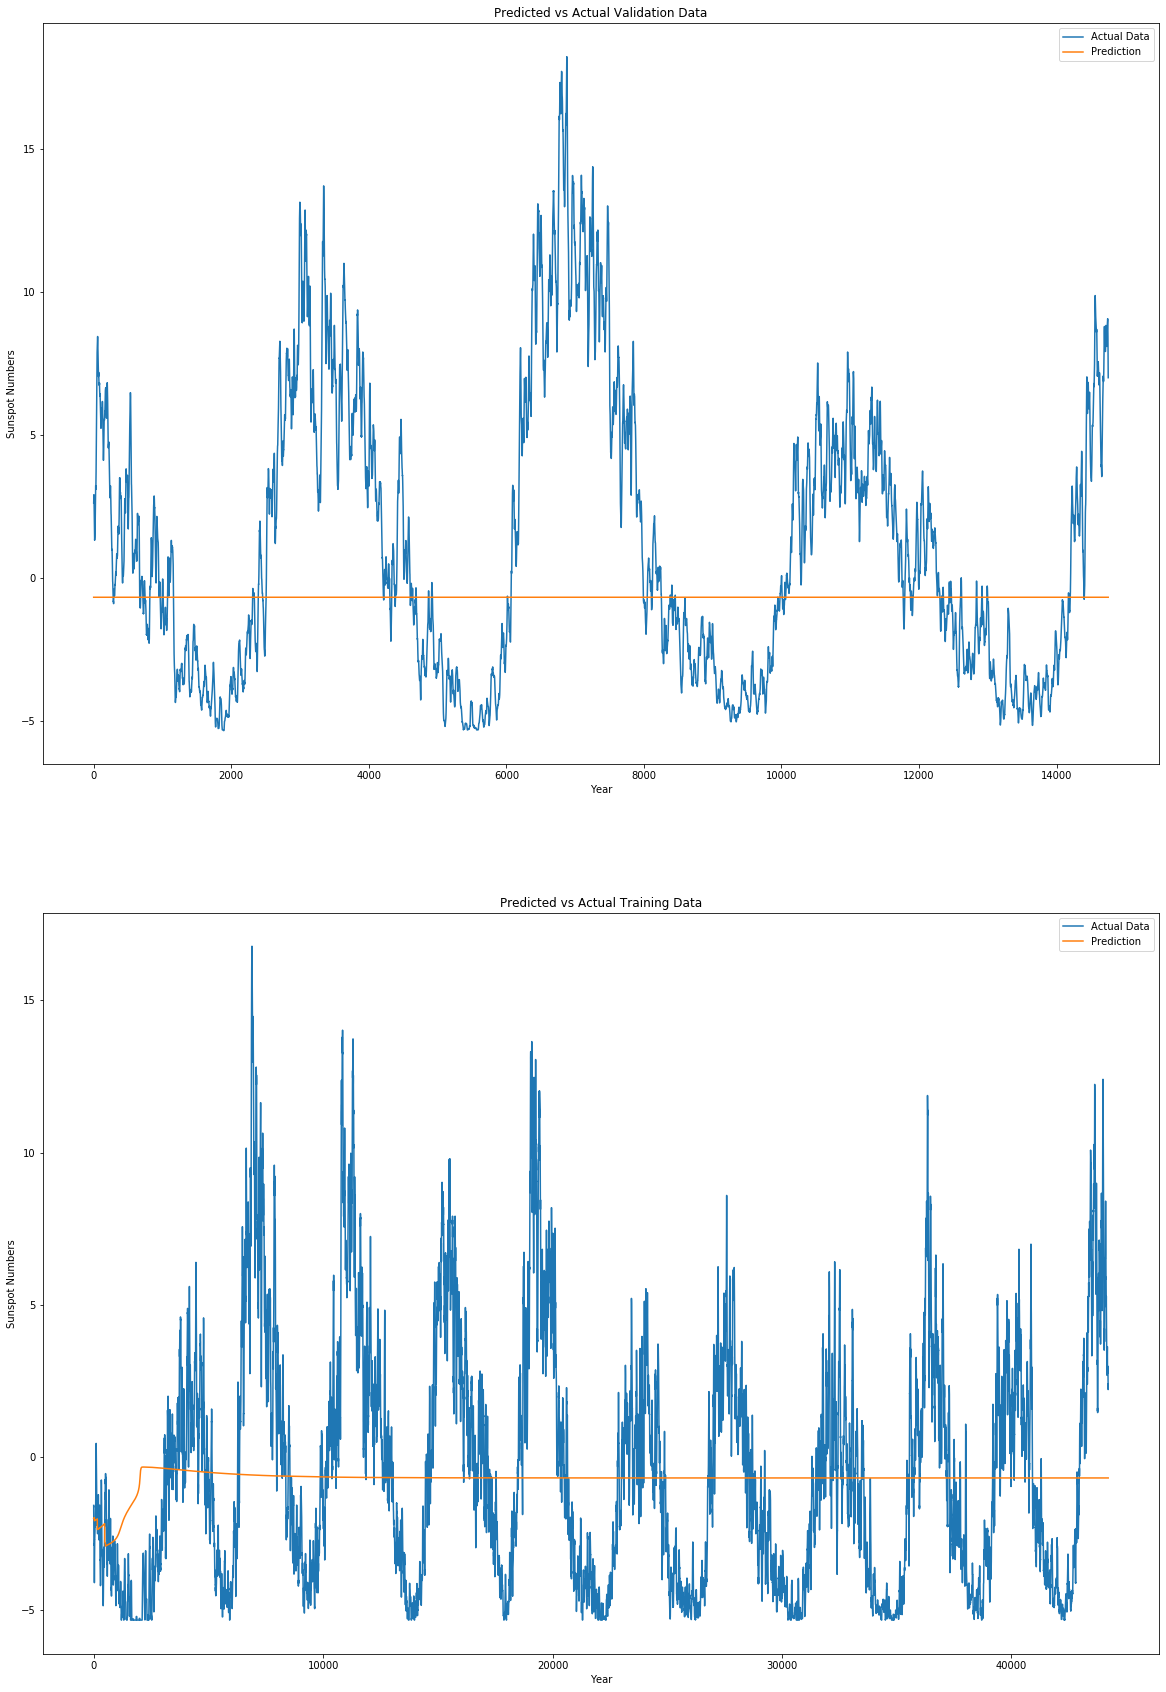

In [40]:
# Plot the prediction on the training and validation set
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 30))
pred1 = net.predict(x_val, batch_size=batch_size)
ax1.plot(y_val, label="Actual Data")
ax1.plot(pred1, label="Prediction")
ax1.set_xlabel("Year")
ax1.set_ylabel("Sunspot Numbers")
ax1.legend()
ax1.set_title("Predicted vs Actual Validation Data")

pred2 = net.predict(x_train, batch_size=batch_size)
ax2.plot(y_train, label="Actual Data")
ax2.plot(pred2, label="Prediction")
ax2.set_xlabel("Year")
ax2.set_ylabel("Sunspot Numbers")
ax2.legend()
ax2.set_title("Predicted vs Actual Training Data")


fig.savefig("predictionvsreal_tanh_tanh_20200204_2layer.png", format="png")
# files.download("predictionvsreal_relu_relu_tanh.png")


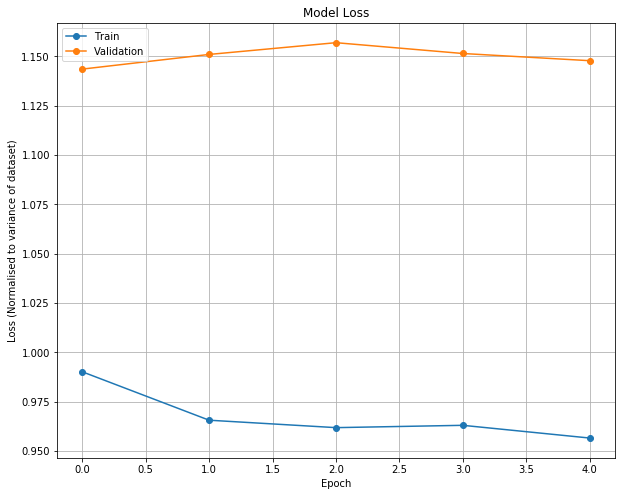

In [41]:
from datetime import datetime

def plot_loss_vs_epoch(history):
  # Plot training & validation loss values
  plt.figure(figsize=(10, 8))
  plt.grid(True)
  plt.plot(history.history['loss']/var_train, marker="o")
  plt.plot(history.history['val_loss']/var_val, marker="o")
  plt.title('Model Loss')
  plt.ylabel('Loss (Normalised to variance of dataset)')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  # plt.ylim(bottom=0)
  plotfilename = datetime.now().strftime("%y%m%d")+ "_lr" + str(learning_rate) + "_epochs" + str(epochs) + "tanh_tanh" + "_2layer" + ".png"
  plt.savefig(plotfilename)
  plt.show()


plot_loss_vs_epoch(history)

In [42]:
def learning_curve():
  loss = []
  val_loss = []
  data_size = []

  x_slid, y_slid = sliding_window_main(x, y)
  x_train, y_train, x_val, y_val, x_test, y_test = data_splitting_main(x_slid, y_slid)
  m_tot = x_train.shape[0]

  batch_step = 50
  try:
    for m in range(batch_size, m_tot, batch_step*batch_size):
      print("Training: ", m)
      net = create_network()
      history = trainer(net, x_train[:m], y_train[:m], x_val, y_val)
      loss.append(history.history["loss"][-1])
      val_loss.append(history.history["val_loss"][-1])
      data_size.append(m)
      print("Loss:", loss[-1])
      print()

  finally:
    plt.plot(data_size, loss, label="Loss", marker="o")
    plt.plot(data_size, val_loss, label="Val Loss", marker="o")
    plt.xlabel("m")
    plt.ylabel("Losses")
    plt.title("Model Loss")
    plt.legend()
    plt.savefig("learning_curve20200117.png")
    plt.show()

    return loss, val_loss

# loss, val_loss = learning_curve()


In [43]:
# If you missed the train I'm on,
# You should know that I'm gone.
# 

In [45]:
tf.test.gpu_device_name()

# z = {"1": 5, "2": 7, "3": 8}

# "\n".join([x + " : " + str(y) for (x, y) in z.items()])

# from platform import python_version
# print(python_version())

''